In [2]:
# 准备数据
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

print(tf.__version__)

2.1.0


In [6]:
#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()

    # 计算当天时间的秒数，记录的时间的开文天文台的时间
    today_ts = ts%(24*60*60)

    # 计算当前的日期时：需要+8表示当前北京时间
    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    # 计算分钟
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    # 计算秒钟
    second = tf.cast(tf.floor(today_ts%60),tf.int32)

    # 是否需要在前面加0
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))

    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*5,end = "")
    tf.print(timestring)

In [3]:
# 正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本，小圆环分布
# 圆的半径+随机值
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
# 圆的角度
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi)
# 计算圆点的位置，利用tf.concat实现数据的拼接
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis=1)
# 标签为1，正样本标签的数据
Yp = tf.ones_like(r_p)

#生成负样本，小圆环分布
# 圆的半径+随机值
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
# 圆的角度
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi)
# 计算圆点的位置，tf.concat将数据在列维度上拼接
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis=1)
# 标签为0，负样本标签的数据
Yn = tf.zeros_like(r_n)

# 汇总数据
X = tf.concat([Xp,Xn],axis=0)
Y = tf.concat([Yp,Yn],axis=0)

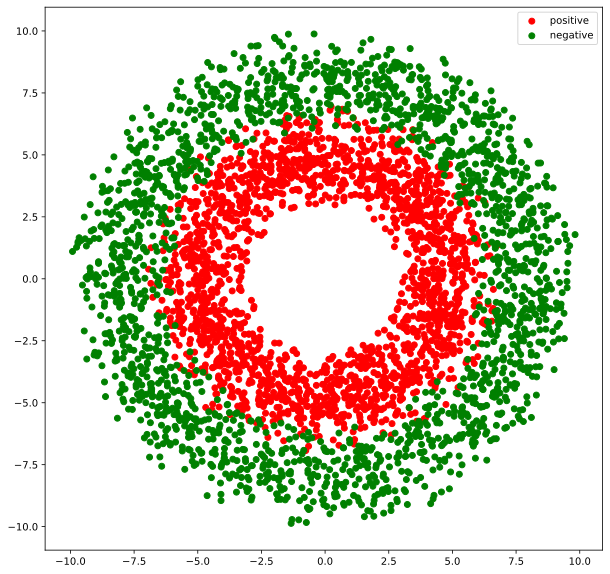

In [7]:
#可视化
plt.figure(figsize = (10,10))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [10]:
# 构建管道数据
ds = tf.data.Dataset.from_tensor_slices((X,Y))\
        .shuffle(buffer_size=4000).batch(100)\
        .prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 定义模型
model